# Exploration of Structure-Aware Line Segment Classification

[Link to the slides](https://docs.google.com/presentation/d/1a_c7ad2dueD3v1S-io3ree2PZ7l1lJwAjxdZ9Dhj0NY/edit#slide=id.g1bb67da435b_0_13)

## Next steps :
- Implement script to download wireframe dataset
- Use a subset of Hypersim
- run lsd and letr on the hypersim dataset subset
- Find a way to compare results
- Implement Dataloader
- Implement Model

Command to export a conda environment with all the dependencies:
```bash 
    conda env export --no-builds | grep -v "^prefix: " > environment.yml
```
Command to create a conda environment from a yml file:
```bash
    conda env create -f environment.yml
```

### Imports

In [1]:
#install PIL
%pip install Pillow


Note: you may need to restart the kernel to use updated packages.


In [61]:
# -*- coding: utf-8 -*-
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pytlsd
from skimage.transform import pyramid_reduce
import pickle
import cv2
import matplotlib.pyplot as plt
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from IPython.display import display
from PIL import Image

## PYTLSD

In [62]:
NOTDEF = -1024.0

def get_thresholded_grad(resized_img):
    modgrad = np.full(resized_img.shape, NOTDEF, np.float64)
    anglegrad = np.full(resized_img.shape, NOTDEF, np.float64)

    # A B
    # C D
    A, B, C, D = resized_img[:-1, :-1], resized_img[:-1, 1:], resized_img[1:, :-1], resized_img[1:, 1:]
    gx = B + D - (A + C)  # horizontal difference
    gy = C + D - (A + B)  # vertical difference

    threshold = 5.2262518595055063
    modgrad[:-1, :-1] = 0.5 * np.sqrt(gx ** 2 + gy ** 2)
    anglegrad[:-1, :-1] = np.arctan2(gx, -gy)
    anglegrad[modgrad <= threshold] = NOTDEF
    return gx, gy, modgrad, anglegrad


In [63]:
def analyze_image_pytlsd(image_path='pytlsd/resources/ai_001_001.frame.0000.color.jpg'):
    gray = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    flt_img = gray.astype(np.float64)

    scale_down = 0.8
    resized_img = pyramid_reduce(flt_img, 1 / scale_down, 0.6)

    # Get image gradients
    gx, gy, gradnorm, gradangle = get_thresholded_grad(resized_img)

    segments = pytlsd.lsd(resized_img, 1.0, gradnorm=gradnorm, gradangle=gradangle)
    segments /= scale_down

    # plt.title("Gradient norm")
    # plt.imshow(gradnorm[:-1, :-1])
    # plt.colorbar()
    # plt.figure()
    # gradangle[gradangle == NOTDEF] = -5
    # plt.title("Thresholded gradient angle")
    # plt.imshow(gradangle[:-1, :-1])
    # plt.colorbar()

    img_color = cv2.cvtColor(gray, cv2.COLOR_GRAY2RGB)
    for segment in segments:
        cv2.line(img_color, (int(segment[0]), int(segment[1])), (int(segment[2]), int(segment[3])), (0, 255, 0))

    return cv2.cvtColor(img_color, cv2.COLOR_BGR2RGB), segments, gradnorm, gradangle

## WIREFRAME Dataset

### Download 

Download the dataset ([link](https://onedrive.live.com/?authkey=%21AGPMjJtoh%5FIn5l8&id=FD0F423C6AB601A4%217290&cid=FD0F423C6AB601A4))
and place it in the `wireframe_dataset` folder.

- Data Structure  
    Each .pkl file contains the annotated wireframe of an image, and it consists of the following variables:  
    ```shell
    *.pkl  
        |-- imagename: 	the name of the image  
        |-- img:         the image data  
        |-- points:      the set of points in the wireframe, each point is represented by its (x,y)-coordinates in the image  
        |-- lines:       the set of lines in the wireframe, each line is represented by the indices of its two end-points  
        |-- pointlines:     the set of associated lines of each point        
        |-- pointlines_index:       line indexes of lines in 'pointlines'  
        |-- junction:       the junction locations, derived from the 'points' and 'lines'  
        |-- theta:      the angle values of branches of each junction                   
    ```

In [64]:
POINT_LINES_PATH = 'wireframe_dataset/pointlines/'
IMG_PATH = 'wireframe_dataset/v1.1/train/'

TRAIN_IMG_NAMES_PATH = 'wireframe_dataset/v1.1/train.txt'

In [65]:
# Load wireframe images

def load_img_points(idx):
    filename = POINT_LINES_PATH + f'{idx}.pkl'
    infile = open(filename,'rb')
    new_dict = pickle.load(infile)
    infile.close()

    im = new_dict['img']
    lines = new_dict['lines']
    points = new_dict['points']

    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    return im, lines, points

In [72]:
# Show wireframe images without and with lines

def print_original_and_image_with_line(id):
    im, lines, points = load_img_points(id)
    imb_before = im.copy()
    for idx, (i, j) in enumerate(lines, start=0):
     x1, y1 = points[i]
     x2, y2 = points[j]
     cv2.line(im, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 2, cv2.LINE_8)

    pytlsd_im = analyze_image_pytlsd(IMG_PATH + f'{id}.jpg')[0]

    # Plot images
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 15))

    axes = [ax1, ax2, ax3]
    for ax in axes:
        ax.set_xticks([])
        ax.set_yticks([])

    ax1.imshow(imb_before)
    ax1.set_title('Original Image')

    ax2.imshow(im)
    ax2.set_title('with ground truth lines')

    ax3.imshow(pytlsd_im)
    ax3.set_title('with PyTSLD lines')
    
    plt.show()

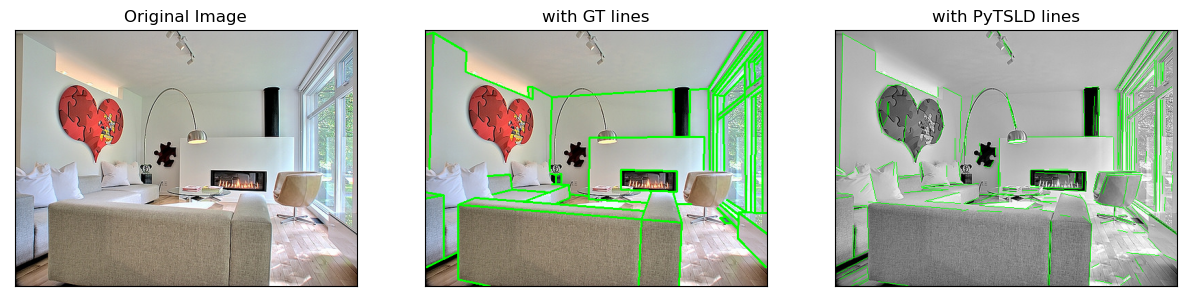

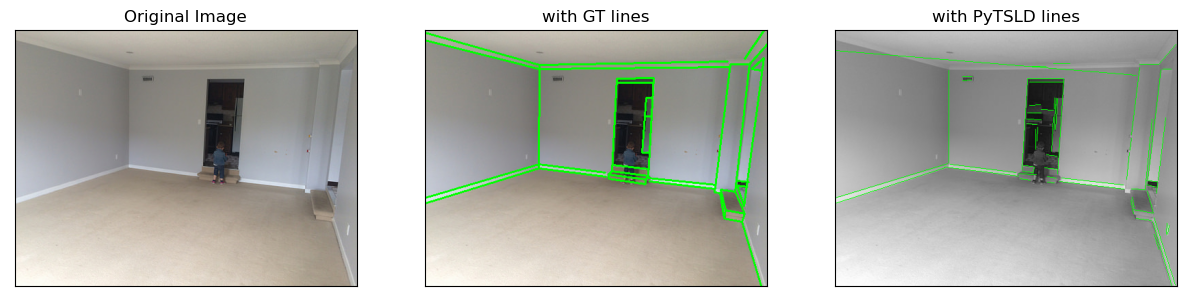

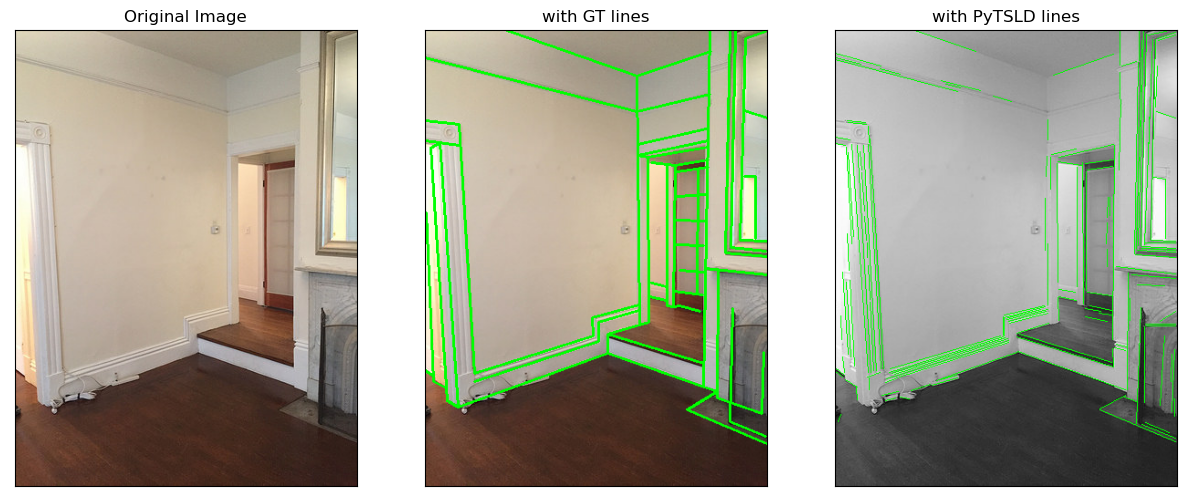

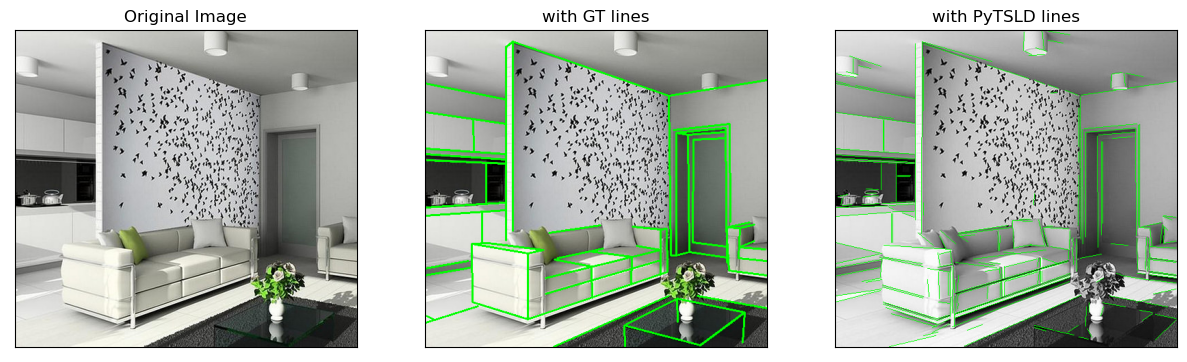

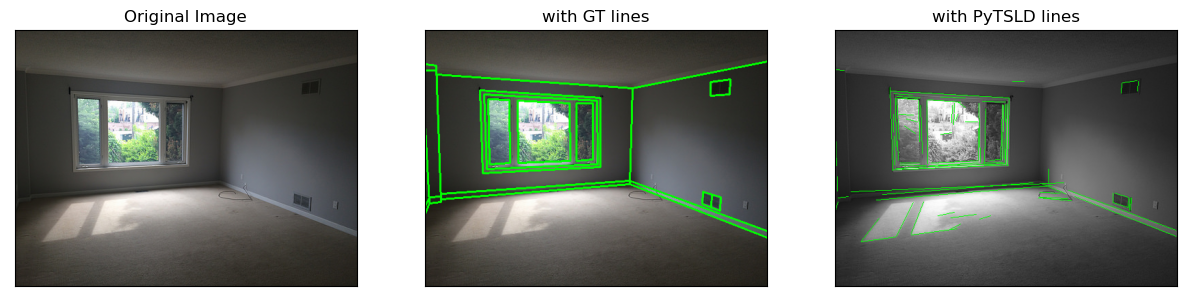

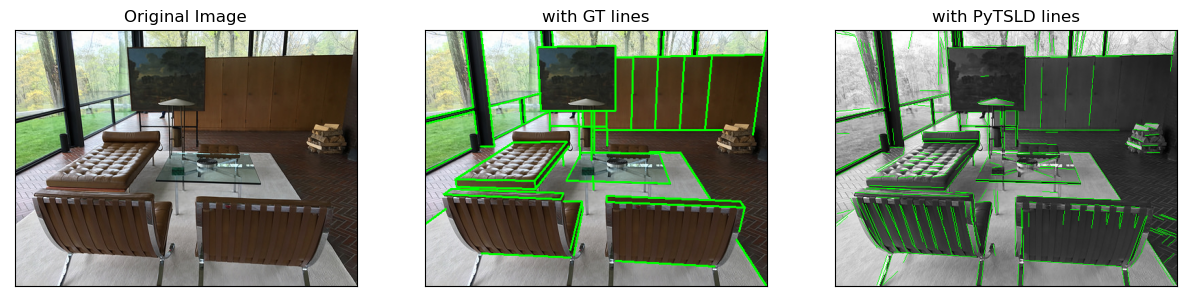

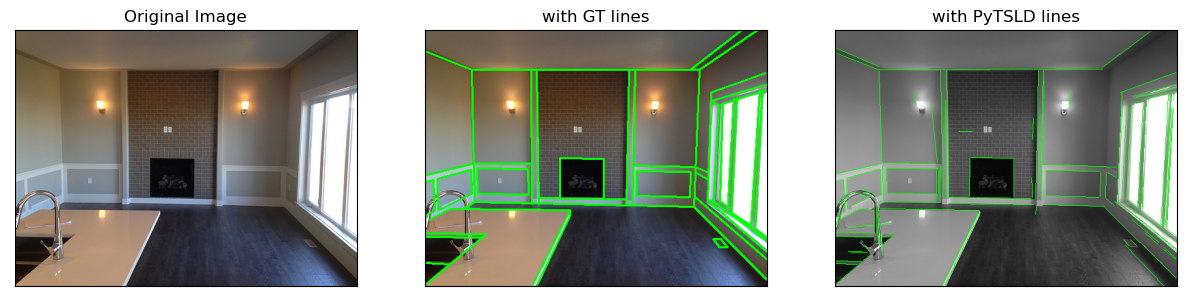

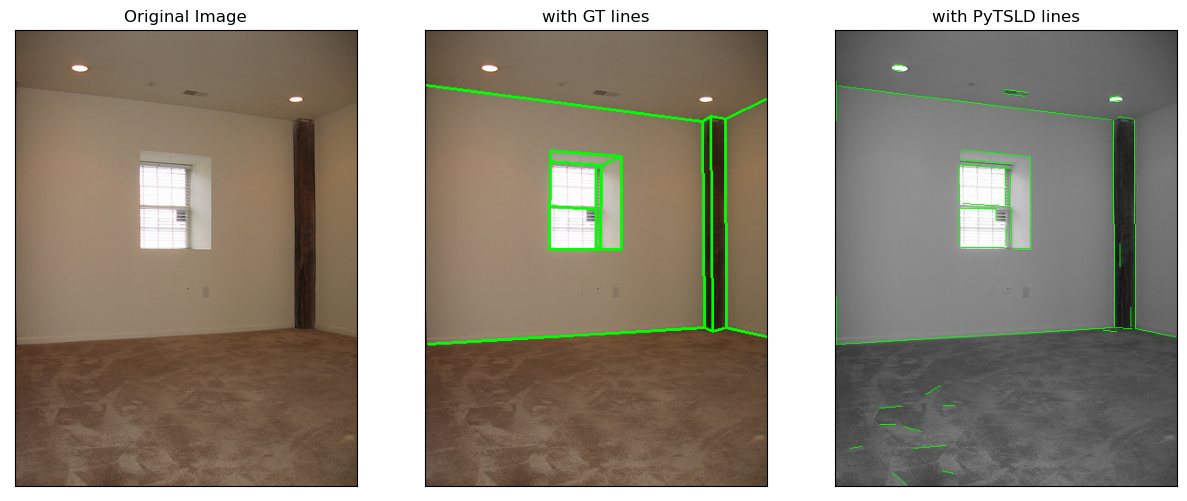

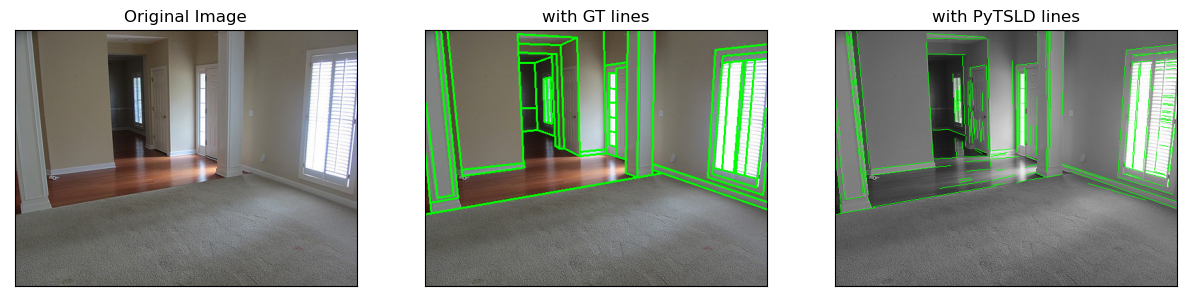

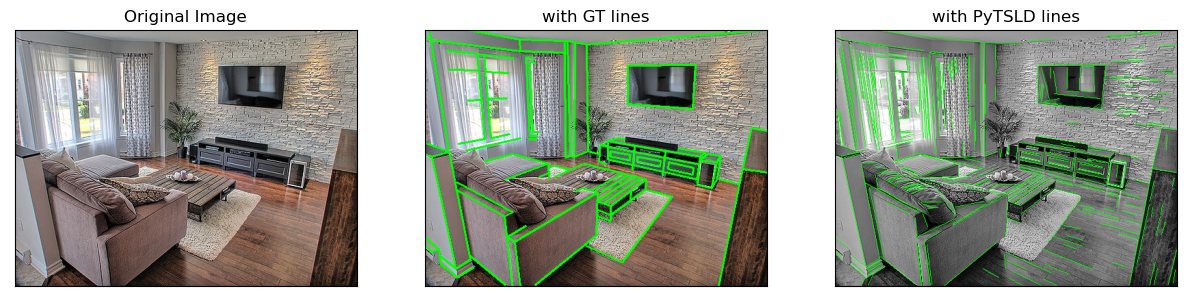

In [75]:
from random import shuffle
with open(TRAIN_IMG_NAMES_PATH) as file:
    # Not really efficent but does the job
    lines = [line.rstrip() for line in file][:10]
    shuffle(lines)
    ids = [line.split('.')[0] for line in lines]
    for id in ids:
        print_original_and_image_with_line(id)


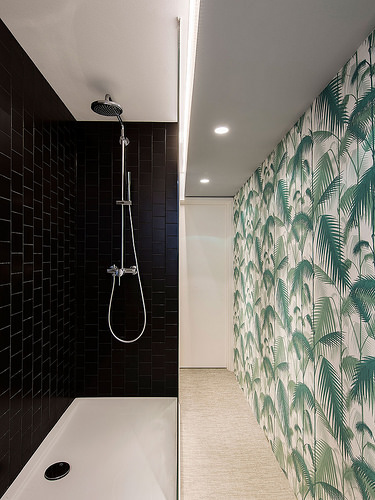

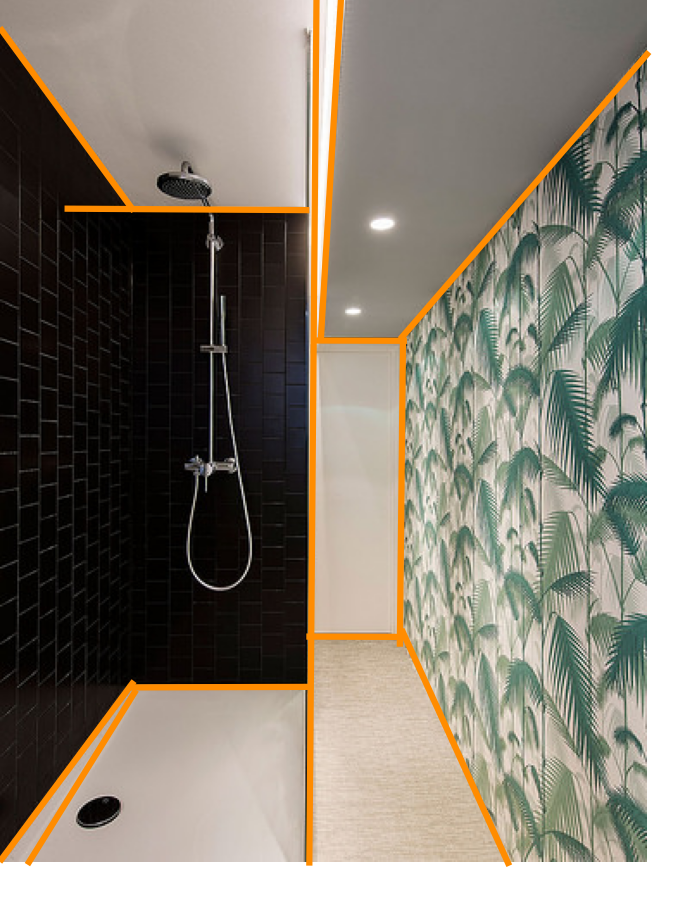

In [68]:

demo_img = Image.open('demo/demo.png')
letr_result = Image.open('demo/demo_letr_result.png')
display(demo_img)
display(letr_result)
images = [] # list of images we use as input
images.append(demo_img)

#### Preprocessing

In [21]:
#resize images
input_dimension_x = 512
input_dimension_y = 512
for image in images:
    image = letr_result.resize((input_dimension_x, input_dimension_y), Image.ANTIALIAS) #antialiasing to avoid pixelation


### Models 

In [27]:
#simple cnn classification
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(512, 512, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(2, activation='softmax')) #softmax for classification
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 510, 510, 32)      896       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 255, 255, 32)     0         
 2D)                                                             
                                                                 
 conv2d_13 (Conv2D)          (None, 253, 253, 64)      18496     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 126, 126, 64)     0         
 2D)                                                             
                                                                 
 conv2d_14 (Conv2D)          (None, 124, 124, 64)      36928     
                                                                 
 flatten_3 (Flatten)         (None, 984064)           

In [28]:
loss_function = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer='adam', loss=loss_function, metrics=['accuracy', 'f1_score'])

In [ ]:
history = model.fit(train_images, train_labels, epochs=10, validation_data=(test_images, test_labels))

#### Stacking LSD with LETR models -> allows for textural classification as well
#### Using new model using LETR for creating the dataset.

In [ ]:
#Using the Wireframe dataset (that already has structural lines detected) LETR for structural line detection. 